# Семинар №1
## Определение языка

В этой лабораторной работе вам предстоит сравнить между собой различные алгоритмы классификации текстов для задачи определения языка. Коллекция текстов состоит из 383,108 текстов на 26 языках.

Ваша задача – сравнить между собой несколько алгоритмов классификации и выбрать лучший из них по аккуратности (accuracy) и F1-мере. 

### Подготовка данных

Для начала посмотрим на [данные](https://www.dropbox.com/s/fkr16tbrh90bq78/TLI.zip?dl=0). Первая колонка здесь – метка класса (язык), вторая – текст, а разделены они табуляцией.

In [1]:
import pandas as pd

data = pd.read_table('data-lang-id.txt', sep='\t')
data.head()

,lang,text
0,ru,Притом же это республиканское устройство бурсы...
1,ru,"Ты упомянул о том, что могло бы привести меня ..."
2,uk,"«Отже йому і спиться, і байдуже — хропе собі!...."
3,pl,"Kiedy słońce, odchodząc za horyzont, poczęło w..."
4,ru,"Странник выудил их всех, всех до единого, и с ..."


In [2]:
data.groupby('lang').count()

,text
lang,
be,14855
bg,14880
cs,1787
de,17509
el,223
en,71581
es,767
fr,9354
hr,1734


In [3]:
# что-то не так...
data.count()

lang    383111
text    383108
dtype: int64

In [4]:
# выкинем строки, в которых есть пустые значения
# и переназначим индексы

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.count()

lang    383108
text    383108
dtype: int64

Теперь нужно разбить данные на тренировочную и тестовую выборку. Кажется, они уже перемешаны, но на всякий случай перемешаем их перед разбиением еще раз.

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

data = shuffle(data)

train, test = train_test_split(data, test_size=0.2)
train.tail()

,lang,text
132941,fr,Le plaisir qu’il y prenait se reflétait sur se...
31184,ru,Алесь привязал коня к забору и медленно пошел ...
255297,en,"Ranged around the building in ring fashion, th..."
198820,pl,"Myślałem o Claire, o wieczorach, które u niej ..."
152289,ru,"Кроме нас двоих, у нее нет никого на земле. Ск..."


## Традиционные алгоритмы классификации
Возможные варианты алгоритмов классификации (можно использовать и другие):
* Наивный Байесовский классификатор [(MultinomialNB)](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* Машины опорных векторов [(SGDClassifier)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
* Случайные леса [(RandomForestClassifier)](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* Метод максимальной энтропии [(LogisticRegression)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Работа со всеми ними в `sklearn` устроена одинаково.

Векторизовать тексты тоже можно по-разному. Для начала попробуем мешок `CountVectorizer` (мешок слов) и `TfidfVectorizer`. Для тех, кто забыл, что такое tf-idf, если примечание в конце конспекта. :)

In [6]:
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

В качестве примера классифицируем тексты как "мешки слов" с помощью наивного байесовского классификатора. Это значит, что каждое слово или каждая н-грамма задает свою координату в векторном пространстве и никаких дополнительных признаков – например, порядок слов – не использует. 

В `sklearn` можно создавать пайплайн, или конвейер из этапов работы над данными: векторизация, классификация и т.д. 

In [7]:
vectorizer = CountVectorizer(ngram_range=(1,1))
classifier = MultinomialNB()

clf = Pipeline([
    ('vect', vectorizer),
    ('clf', classifier),
])

# учим классификатор
%time clf.fit(train.text, train.lang)

Wall time: 1min 32s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Смотрим показания классификатора на тестовом множестве. 

In [8]:
predictions = clf.predict(test.text)

Оцениваем качество.

In [17]:
# макро-усреднение
print("Precision: {0:6.2f}".format(precision_score(test.lang, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(test.lang, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(test.lang, predictions, average='macro')))

print("...")
# микро-усреднение
print("Precision: {0:6.2f}".format(precision_score(test.lang, predictions, average='micro')))
print("Recall: {0:6.2f}".format(recall_score(test.lang, predictions, average='micro')))
print("F1-measure: {0:6.2f}".format(f1_score(test.lang, predictions, average='micro')))

print("...")
# accuracy
print("Accuracy: {0:6.2f}".format(accuracy_score(test.lang, predictions)))

Precision:   0.99
Recall:   0.99
F1-measure:   0.99
...
Precision:   1.00
Recall:   1.00
F1-measure:   1.00
...
Accuracy:   1.00


In [18]:
print(classification_report(test.lang, predictions))

              precision    recall  f1-score   support

          be       1.00      1.00      1.00      3078
          bg       1.00      1.00      1.00      3074
          cs       1.00      1.00      1.00       358
          de       1.00      1.00      1.00      3475
          el       1.00      1.00      1.00        40
          en       1.00      1.00      1.00     14231
          es       1.00      1.00      1.00       148
          fr       0.99      1.00      1.00      1873
          hr       0.86      1.00      0.92       349
         hsb       1.00      1.00      1.00        36
          hy       1.00      1.00      1.00       916
          it       1.00      1.00      1.00       663
          la       1.00      1.00      1.00        95
          lt       1.00      1.00      1.00        17
          lv       1.00      1.00      1.00       496
          mk       1.00      1.00      1.00       381
          nl       1.00      1.00      1.00       416
          pl       1.00    

Визуализируем результаты.

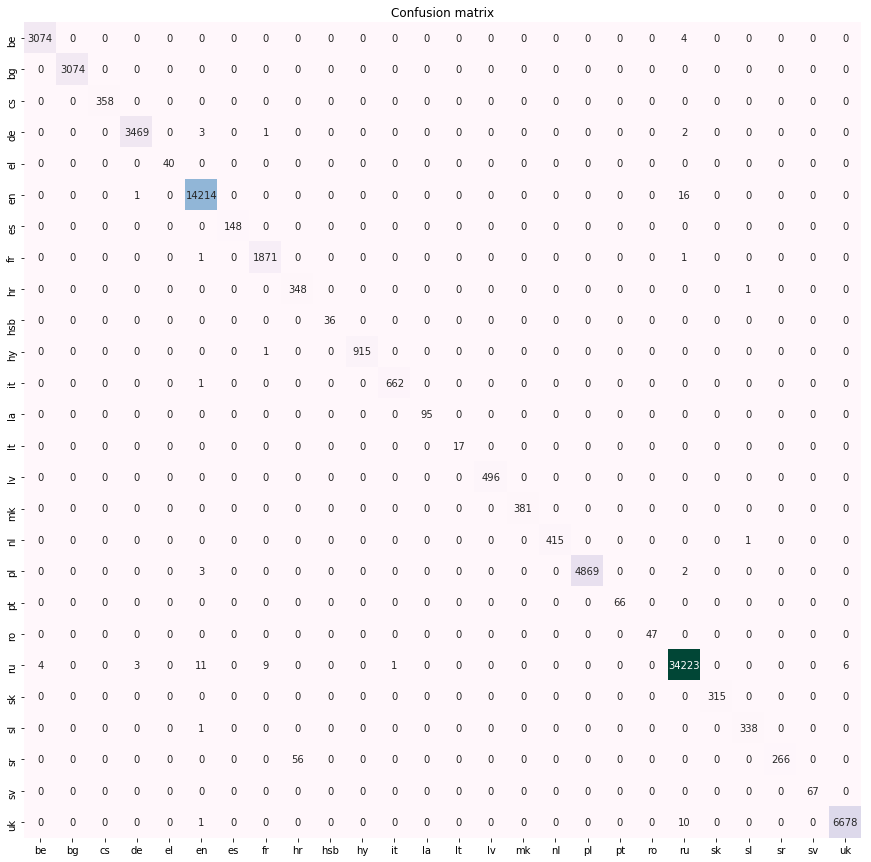

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.lang, predictions)

labels = clf.classes_
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Важность признаков

Веса признаков в линейной модели в случае, если признаки отмасштабированы, характеризуют степень их влияния на значение целевой переменной. В задаче классификации текстов, кроме того, признаки являются хорошо интерпретируемыми, поскольку каждый из них соответствует конкретному слову. Изучим влияние конкретных слов на значение целевой переменной.

In [12]:
f_weights = zip(vectorizer.get_feature_names(), classifier.coef_[0])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])
    
print('...')
for i in reversed(range(1,10)):
    print('%s, %.2f' % f_weights[i])

не, -4.68
на, -4.83
што, -5.13
ён, -5.53
як, -5.68
да, -5.80
яго, -5.80
за, -5.97
але, -6.05
па, -6.15
гэта, -6.15
ад, -6.34
яна, -6.36
было, -6.37
калі, -6.45
ты, -6.45
яе, -6.51
так, -6.59
яшчэ, -6.65
яны, -6.65
каб, -6.65
толькі, -6.68
быў, -6.84
іх, -6.84
тут, -6.86
мяне, -6.87
пра, -6.92
пад, -6.94
сказаў, -6.96
...
039, -14.49
025, -14.49
02, -14.49
016, -14.49
015, -14.49
011, -14.49
0083, -14.49
007, -14.49
003, -14.49


### Задание

Итак, ваша задача – проделать то же самое с другими классификаторами и сравнить их качество, а потом векторизовать слова с помощью `TfidfVectorizer` и проверить, влияет ли это на качество результатов классификации.

### Напоминание: TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) *(Term Frequency – Inverse Document Frequency)*. Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

**1. Term Frequency** – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.


**2. Inverse Document Frequency**
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.